# N2V Prediction
Please run the ```1_N2VTraining.ipynb``` before.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from ppn2v.pn2v.utils import PSNR
from ppn2v.pn2v import utils
from ppn2v.pn2v import prediction

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [7]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse skull nuclei/Mouse skull nuclei/'

# Load the test data
dataTest=imread(path+"example2_digital_offset300.tif")[:,:,:256] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```01_N2VTraining.ipynb```.

In [8]:
dataName = 'mouseskullnuclei' # Use the same name as used in N2VTraining.ipynb. This is a part of model name created in N2VTraining.ipynb 
nameModel=dataName+'_n2v'

### Load the Network

In [9]:
# Load the network, created in the '01_N2VTraining.ipynb' notebook
net=torch.load(path+"/last_"+nameModel+".net")

### Evaluation

image: 0
PSNR input 28.02423798473431
PSNR prior 35.62975342511759
PSNR mse 35.62975342511759
-----------------------------------
image: 1
PSNR input 28.065531602490644
PSNR prior 35.76115148796612
PSNR mse 35.76115148796612
-----------------------------------
image: 2
PSNR input 28.035021421910734
PSNR prior 35.75344569221387
PSNR mse 35.75344569221387
-----------------------------------
image: 3
PSNR input 28.087744381628678
PSNR prior 35.78943842163468
PSNR mse 35.78943842163468
-----------------------------------
image: 4
PSNR input 28.061745249613562
PSNR prior 35.68027927567376
PSNR mse 35.68027927567376
-----------------------------------
image: 5
PSNR input 28.1086316653067
PSNR prior 35.78950530836388
PSNR mse 35.78950530836388
-----------------------------------
image: 6
PSNR input 28.11584919615069
PSNR prior 35.85117921581496
PSNR mse 35.85117921581496
-----------------------------------
image: 7
PSNR input 28.078571033189487
PSNR prior 35.79310189446516
PSNR mse 35.7931018

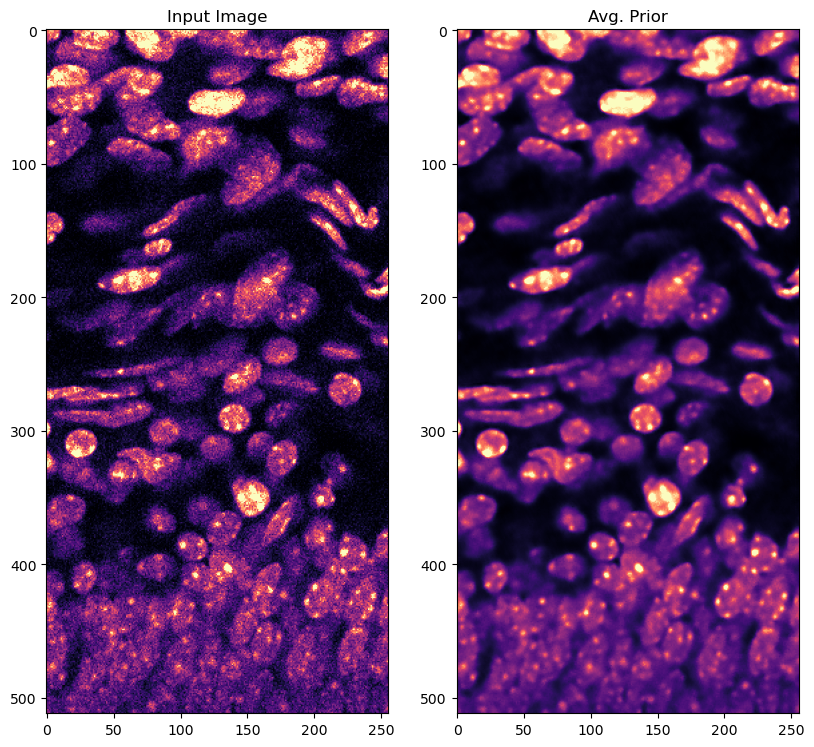

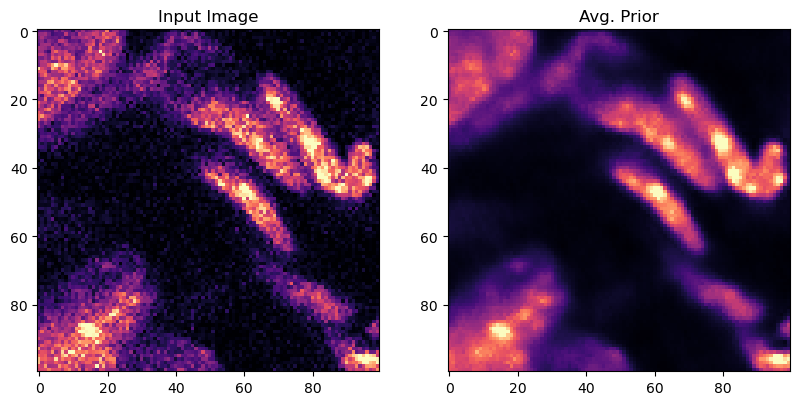

In [10]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    
    means = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    resultImgs.append(means)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, means,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )